## Part 1: Geometry of the feature space
The first crucial thing to internalize with all classification algorithms is that they make certain assumptions about how features are distributed and how features and classes are connected.

### Question 1
Go back through the lectures and answer the following questions:

What assumptions do the following methods make about the distribution of features for a certain class? What does this mean abstractly but also visually?

1. Linear discriminant analysis

For LDA multiple assumptions are made hower it can perform decent even if the assumptions are violated. The data set is assumed to have a (multivariate) gaussian distribution for each of the independent features. It assumes the data has a common covariance matrix but a class-specific mean vector and that there are no outliers.

2. Quadratic discriminant analysis

QDA assumes the data set to have a multivariate gaussian distribution. Different from LDA, the QDA assumes that each class has a class-specific covariance matrix.

3. kNN

kNN makes no assumption regarding the data distribution but instead assumes that the neighbourhood of features are important, basically that classes exists in close proximity. Even though a suitable “k” can be determined, it sets the number of neighbors to consider when classifying a observation. For example a low “k” can encircle small cluster of a given class close to another class.

4. CART

CART models is preferable for large data sets with almost no preprocessing since it doesn’t take any assumptions regarding data distribution, variable linearity and so on.


Visual representation of the distributions discussed above. The first figure shows a good case for using LDA, then second for using QDA and the last one is when kNN could be used.

![alt text](different_dist.png "Different distributions")

Also think about the impact of $k$ in kNN and the impact of different parameters on the CART model

**Hint** Think about how each algorithm performs the classification. This tells you a lot about how features and classes are related. In more abstract terms (if that is your thing), think not just about a single 
$p(x|i)$ but also think about how these distributions are connected with the resulting classification rule $c(x)$. For example, nearest centroids classification assumes that $p(x|i) = N(x;μ_i,σ^2I)$ and then assigns classes using the decision rule

$$
c(x) = argmin_i||x-\mu_i||_2
$$

### Question 2

For the following questions focus on QDA and CART.

1) Simulate training and test data that follows the assumptions for each of the two models. (QDA, CART)

2) What are your expectations on the test error if you were to apply QDA to data simulated for CART and vice versa?

3) Train the methods on both training data sets and compare their respective test errors for each dataset. Were your expectations from Step 2 correct? Any surprises? Discuss!

4) Taking what you have learned from the project so far, can you simulate data for which the target method works best? (Clarifying example: Data simulated for QDA should be classified best by QDA and less well CART, and the other way around)

Note Make sure you repeat the simulation of the data many times. A result based on a single training and test dataset could be pure chance, especially due to the instability of CART. Write your code in such a fashion that you can easily create many training and test datasets repeat the comparison described above. Always report average values but always with a measure of uncertainty (e.g. standard deviation).

For most practical purposes you would not use a single CART model, but rather a bagged version or Random Forests. This exercise is meant to give you a feeling of the different capabilities of the two models.



**Answer:**
1) Data simulated below, data for QDA being gaussian, and for CART it is uniform.

2) Applying the "wrong" model to the data will give worse results, fitting a normal distribution to a uniform dataset will not yield optimal results. The same is true for the opposite case.

3) The expectations were mostly correct with some minor suprises we did not expect. QDA on the gaussian data below yields some errors, which is to be expected since the data overlaps somewhat. CART on the chosen data yields zero errors pretty much every time since there is enough data for the estimated boundaries to end up almost exactly at the true boundaries. When the models are applied on inappropriate data, we get more errors as we expected. CART on gaussian data gave zero training loss (zero one loss) which I found slightly surprising but is reasonable since the boundaries can be adapted to fit any outliers in more improbable locations. In the test set this results in quite high errors from unorthodox boundaries made to fit outliers. QDA on the CART data gives similar errors for both training and test sets. At first I found this surprising as I thought the training error would be somewhat lower than the test error, but just as often we seem to get the opposite. Given a second thought, this is reasonable since we are essentially trying to fit a square peg in a round hole in either case, only with more data in the training set. More data doesn't make fitting that much easier in this case, only that the error should be more consistent. With fewer data points the test error varies more between runs, but on average performs equally as the training.

4) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from prettytable import PrettyTable


In [2]:
def plot_data(X_train, y_train, X_test, y_test, title = ''):
    # Plot the two data classes
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    axs[0].plot(X_train[y_train == 0][:,0], X_train[y_train == 0][:,1], 'o', markersize=8, label='y=0')
    axs[0].plot(X_train[y_train == 1][:,0], X_train[y_train == 1][:,1], 'o', markersize=8, label='y=1')

    axs[1].plot(X_test[y_test == 0][:,0], X_test[y_test == 0][:,1], 'o', markersize=8, label='y=0')
    axs[1].plot(X_test[y_test == 1][:,0], X_test[y_test == 1][:,1], 'o', markersize=8, label='y=1')

    for ax in axs:
        ax.legend()
        ax.grid()

    axs[0].set_title('Training')
    axs[1].set_title('Test')

    fig.suptitle(title)
    return fig, axs

def decision_boundary(model, fig, axs, levels = [0.1, 0.5, 0.9], labels = True):
    # Code for producing the plot
    min_x = np.inf
    max_x = -np.inf
    min_y = np.inf
    max_y = -np.inf
    for ax in axs:
        if ax.get_xlim()[0] < min_x:
            min_x = ax.get_xlim()[0]
        if ax.get_xlim()[1] > max_x:
            max_x = ax.get_xlim()[1]
        if ax.get_ylim()[0] < min_y:
            min_y = ax.get_ylim()[0]
        if ax.get_ylim()[1] > max_y:
            max_y = ax.get_ylim()[1]

    X1 = np.linspace(min_x, max_x,100)
    X2 = np.linspace(min_y, max_y, 100)
    Z = np.zeros(X1.shape+X2.shape)

    for ax in axs:
        for i,x1 in enumerate(X1):
            for j,x2 in enumerate(X2):
                y_prob = model.predict(np.array([x1,x2]).reshape(1,-1))
                Z[j,i] = y_prob[0]
                
        contours = ax.contour(X1,X2,Z, levels=levels)
        if labels:
            ax.clabel(contours, inline=1, fontsize=10)
    
    return fig, axs

Training Loss = 0.06666666666666665
Test Loss = 0.12


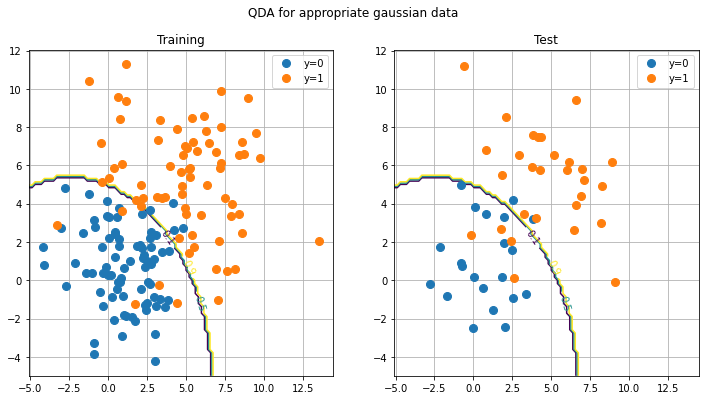

In [3]:
# 1) QDA

sz = (100,2)
x_gaus = np.random.normal(loc=[1,1], scale=[2,2], size=sz)
y_g = np.ones(200)
y_g[:100] = 0
x_gaus = np.append(x_gaus, np.random.multivariate_normal(mean=[5,5], cov=[[8,-2], [-2,8]], size=100), axis=0)

x_g_train, x_g_test, y_g_train, y_g_test = train_test_split(x_gaus, y_g) 
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_g_train, y_g_train)

y_g_train_pred = qda.predict(x_g_train)
print(f'Training Loss = {zero_one_loss(y_g_train, y_g_train_pred)}')
y_g_pred = qda.predict(x_g_test)
print(f'Test Loss = {zero_one_loss(y_g_test, y_g_pred)}')

fig, ax = plot_data(x_g_train, y_g_train, x_g_test, y_g_test, f'QDA for appropriate gaussian data')
fig, ax = decision_boundary(qda, fig, ax)


Training Loss = 0.0
Test Loss = 0.0


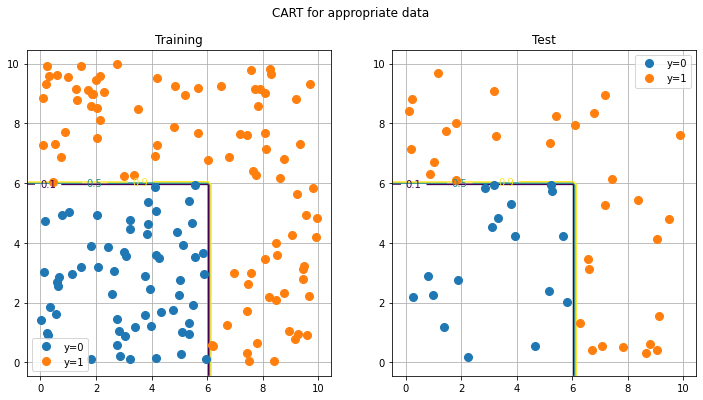

In [4]:

# 1) CART
x_uni = np.random.uniform(low=0, high=10, size=(200,2))
y_uni = np.any(x_uni>6, axis=1)

x_u_train, x_u_test, y_u_train, y_u_test = train_test_split(x_uni, y_uni) 

cart = DecisionTreeClassifier()
cart.fit(x_u_train, y_u_train)


y_u_train_pred = cart.predict(x_u_train)
print(f'Training Loss = {zero_one_loss(y_u_train, y_u_train_pred)}')
y_u_pred = cart.predict(x_u_test)
print(f'Test Loss = {zero_one_loss(y_u_test, y_u_pred)}')

fig, ax = plot_data(x_u_train, y_u_train, x_u_test, y_u_test, f'CART for appropriate data')
fig, ax = decision_boundary(cart, fig, ax)

### Now for fitting the models to the inappropriate datasets to see how they fare.

Training Loss = 0.0
Test Loss = 0.14


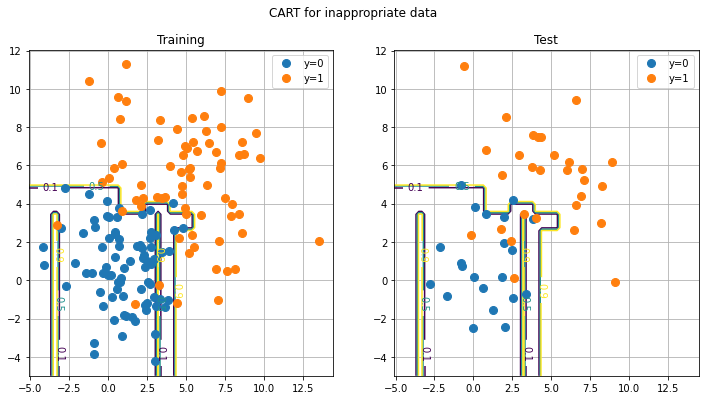

In [5]:
cart2 = DecisionTreeClassifier()
cart2.fit(x_g_train, y_g_train)

y_g_train_pred = cart2.predict(x_g_train)
print(f'Training Loss = {zero_one_loss(y_g_train, y_g_train_pred)}')
ygc_pred = cart2.predict(x_g_test)
print(f'Test Loss = {zero_one_loss(y_g_test, ygc_pred)}')

fig, ax = plot_data(x_g_train, y_g_train, x_g_test, y_g_test, f'CART for inappropriate data')
fig, ax = decision_boundary(cart2, fig, ax)

Training Loss = 0.046666666666666634
Test Loss = 0.12


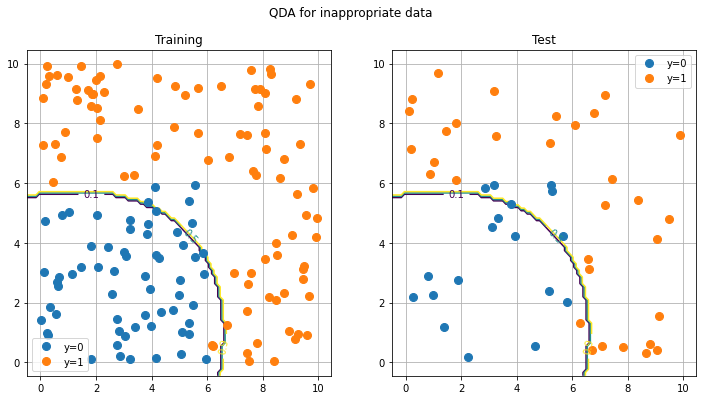

In [6]:
qda2 = QuadraticDiscriminantAnalysis()
qda2.fit(x_u_train, y_u_train)

y_u_train_pred = qda2.predict(x_u_train)
print(f'Training Loss = {zero_one_loss(y_u_train, y_u_train_pred)}')
yuq_pred = qda2.predict(x_u_test)
print(f'Test Loss = {zero_one_loss(y_u_test, yuq_pred)}')

fig, ax = plot_data(x_u_train, y_u_train, x_u_test, y_u_test, f'QDA for inappropriate data')
fig, ax = decision_boundary(qda2, fig, ax)

## Part 2: Actual data and classification metrics
For this question we will work with the UCI breast cancer dataset.

In [7]:
# Load UCI breast cancer dataset with column names and remove ID column
uci_bc_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", 
    sep=",",
    header=None,
    names=[
        "id_number", "diagnosis", "radius_mean",
        "texture_mean", "perimeter_mean", "area_mean",
        "smoothness_mean", "compactness_mean",
        "concavity_mean","concave_points_mean",
        "symmetry_mean", "fractal_dimension_mean",
        "radius_se", "texture_se", "perimeter_se",
        "area_se", "smoothness_se", "compactness_se",
        "concavity_se", "concave_points_se",
        "symmetry_se", "fractal_dimension_se",
        "radius_worst", "texture_worst",
        "perimeter_worst", "area_worst",
        "smoothness_worst", "compactness_worst",
        "concavity_worst", "concave_points_worst",
        "symmetry_worst", "fractal_dimension_worst"
    ],).drop("id_number", axis=1)

y = uci_bc_data.diagnosis.map({"B": 0, "M": 1}).to_numpy()
X = uci_bc_data.drop("diagnosis", axis=1).to_numpy()

When starting to investigate a classification dataset, there should be two basic steps you always (and especially now) take.

1. Investigate if the class labels are balanced or imbalanced.
2. Investigate the features

    a) Are they numerical or categorical?
    
    b) Do they have highly varying scales? Should data be scaled/normalized/centred before being used in a classification method? (More on this in lecture 5)
    
    c) How does the correlation matrix between the features look like? Are there highly correlated features? Are there plausible reasons for the correlations?

In [8]:
# Investigate if the class labels are balanced or imbalanced
print(sum(y)/len(y))

0.37258347978910367


So the class is slightly imbalanced, having more benign than malignant examples.

**a)** They are all numerical after we map the classification to 0 and 1 from 'B' and 'M'.

**b)** They do seem to have quite highly varying scales, things like the area has thousands of times larger values than some other. Or if you mean the standard error, that is true for some features as well.

**c)** Some of the features are very highly correlated. Things like mean area, perimeter, and radius should reasonably be highly correlated in the data as they are different measures of the size of tumors. This shows in the correlation matrix, with these covariances being near 1. 

In [9]:
print(uci_bc_data)
print(uci_bc_data.corr())

    diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0           M        17.99         10.38          122.80     1001.0   
1           M        20.57         17.77          132.90     1326.0   
2           M        19.69         21.25          130.00     1203.0   
3           M        11.42         20.38           77.58      386.1   
4           M        20.29         14.34          135.10     1297.0   
..        ...          ...           ...             ...        ...   
564         M        21.56         22.39          142.00     1479.0   
565         M        20.13         28.25          131.20     1261.0   
566         M        16.60         28.08          108.30      858.1   
567         M        20.60         29.33          140.10     1265.0   
568         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0            0.11840           0.27760         0.30010              

In [10]:
print(uci_bc_data)

    diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0           M        17.99         10.38          122.80     1001.0   
1           M        20.57         17.77          132.90     1326.0   
2           M        19.69         21.25          130.00     1203.0   
3           M        11.42         20.38           77.58      386.1   
4           M        20.29         14.34          135.10     1297.0   
..        ...          ...           ...             ...        ...   
564         M        21.56         22.39          142.00     1479.0   
565         M        20.13         28.25          131.20     1261.0   
566         M        16.60         28.08          108.30      858.1   
567         M        20.60         29.33          140.10     1265.0   
568         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0            0.11840           0.27760         0.30010              

### Question 3
As mentioned above, it is more important for us to discover malignant tumours.

1. Choose a classification methods (classifier) and test the effect of different classification metrics (such as accuracy, specificity, the F1 score, etc.). What I mean by this is the following
    - Split your data into a bunch of folds (do this without stratification for now)
    - For each fold $\mathcal{F}$:
        - Train a model on the remaining training folds using the models standard mode of training (e.g. optimisation of a likelihood in the case of QDA, splitting on the Gini score in CART or Random Forest)
        - Compute classification metrics on the test fold $\mathcal{F}$
    - Report the average performance across folds
2. Which classification metric(s?) is/are most suitable for our goal here? **Explain why**!
3. Choose one additional classification method that is substantially different (i.e. QDA and Random Forest, or logistic regression and CART. Not QDA and LDA, or logistic regression and LDA, they are too similar in their assumptions) and compare the two methods using the best classification metric(s) you determined in Step 2.
4. Does using stratified cross-validation change/improve your results?

2. Since we need to focus on discovering malignant tumors, it is more important that we get as many true positives (positives being malignant tumors in this case) and as few false negatives as possible. Recall is the fraction of true positives of all positives, so $\frac{TP}{TP+FN}$. This score is better when we find every single malignant case, and is punished every time there is a false negative, eg we missed a dangerous tumor. Evaluating the classification methods with the recall metric therefor gives us an indication of how well we manage to identify every single malignant tumor which is what we want to focus on.

3. We chose to compare QDA with Random Forest. For the Random Forest we set max depth to 2 and used 100 trees. Comparing the recall metric for the two methods, we see that QDA outperforms RF in this case. The recall for QDA is around $0.95$, while the recall for RF ends up about around $0.9$, which is $0.05$ lower. This means that RF is more prone to misclassify the malignant observations which is unsuitable in this case.

4. When repeating the process with stratified cross-validation, the results were quite similar. QDA still outperformed RF, by a slightly smaller margin of about $0.04$ for the recall metric.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
kf.get_n_splits(X_train)
kfs = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
kfs.get_n_splits(X_train, y_train)

10

In [12]:
qda = QuadraticDiscriminantAnalysis()
rfc = RandomForestClassifier(max_depth=2, random_state=0)

def get_preds(pred_y, true_y):
    TP, FP, TN, FN = 0, 0, 0, 0
    for pred_y, true_y in zip(pred_y, true_y):
        if pred_y == 1 and true_y == 1:
            TP += 1
        elif pred_y == 1 and true_y == 0:
            FP += 1
        elif pred_y == 0 and true_y == 0:
            TN += 1
        else:
            FN += 1
    
    return TP, FP, TN, FN

qda_acc = np.empty(0)
rfc_acc = np.empty(0)
qda_F1 = np.empty(0)
rfc_F1 = np.empty(0)
qda_precision = np.empty(0)
rfc_precision = np.empty(0)
qda_recall = np.empty(0)
rfc_recall = np.empty(0)
qda_specificity = np.empty(0)
rfc_specificity = np.empty(0)

for train_index, val_index in kf.split(X_train):
    F_X_train = [X_train[idx] for idx in train_index]
    F_y_train = [y_train[idx] for idx in train_index]
    qda.fit(F_X_train, F_y_train)
    rfc.fit(F_X_train, F_y_train)

    F_X_test = [X_train[idx] for idx in val_index]
    F_y_test = [y_train[idx] for idx in val_index]
    
    qda_acc = np.append(qda_acc, qda.score(F_X_test, F_y_test))
    rfc_acc = np.append(rfc_acc, rfc.score(F_X_test, F_y_test))
    
    qda_preds = qda.predict(F_X_test)
    rfc_preds = rfc.predict(F_X_test)

    qda_TP, qda_FP, qda_TN, qda_FN = get_preds(qda_preds, F_y_test)
    rfc_TP, rfc_FP, rfc_TN, rfc_FN = get_preds(rfc_preds, F_y_test)

    qda_F1 = np.append(qda_F1, qda_TP / (qda_TP + 0.5*(qda_FP+qda_FN)))
    rfc_F1 = np.append(rfc_F1, rfc_TP / (rfc_TP + 0.5*(rfc_FP+rfc_FN)))
    
    qda_precision = np.append(qda_precision, qda_TP / (qda_TP + qda_FP))
    rfc_precision = np.append(rfc_precision, rfc_TP / (rfc_TP + rfc_FP))
    
    qda_recall = np.append(qda_recall, qda_TP / (qda_TP + qda_FN)) # Also called sensetivity
    rfc_recall = np.append(rfc_recall, rfc_TP / (rfc_TP + rfc_FN))
    
    qda_specificity = np.append(qda_specificity, qda_TN / (qda_TN + qda_FP))
    rfc_specificity = np.append(rfc_specificity, rfc_TN / (rfc_TN + rfc_FP))
    

t = PrettyTable(['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'Specificity'])
t.add_row(['QDA', qda_acc.mean(), qda_F1.mean(), qda_precision.mean(), qda_recall.mean(), qda_specificity.mean()])
t.add_row(['Random Forest', rfc_acc.mean(), rfc_F1.mean(), rfc_precision.mean(), rfc_recall.mean(), rfc_specificity.mean()])
print(t)

+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     Model     |      Accuracy      |      F1 Score      |     Precision      |       Recall       |    Specificity     |
+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      QDA      | 0.9559903381642512 | 0.940801861700654  | 0.9438958470150421 | 0.9393612106847401 | 0.9643281912747987 |
| Random Forest | 0.9429468599033817 | 0.9203005359856149 | 0.9536146281254977 | 0.8920824355383179 | 0.9707018914993053 |
+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+


### Now with stratified cross-validation:

In [13]:
qda = QuadraticDiscriminantAnalysis()
rfc = RandomForestClassifier(max_depth=2, random_state=0)

qda_acc = np.empty(0)
rfc_acc = np.empty(0)
qda_F1 = np.empty(0)
rfc_F1 = np.empty(0)
qda_precision = np.empty(0)
rfc_precision = np.empty(0)
qda_recall = np.empty(0)
rfc_recall = np.empty(0)
qda_specificity = np.empty(0)
rfc_specificity = np.empty(0)

for train_index, val_index in kfs.split(X_train, y_train):
    F_X_train = [X_train[idx] for idx in train_index]
    F_y_train = [y_train[idx] for idx in train_index]
    qda.fit(F_X_train, F_y_train)
    rfc.fit(F_X_train, F_y_train)

    F_X_test = [X_train[idx] for idx in val_index]
    F_y_test = [y_train[idx] for idx in val_index]
    
    qda_acc = np.append(qda_acc, qda.score(F_X_test, F_y_test))
    rfc_acc = np.append(rfc_acc, rfc.score(F_X_test, F_y_test))
    
    qda_preds = qda.predict(F_X_test)
    rfc_preds = rfc.predict(F_X_test)

    qda_TP, qda_FP, qda_TN, qda_FN = get_preds(qda_preds, F_y_test)
    rfc_TP, rfc_FP, rfc_TN, rfc_FN = get_preds(rfc_preds, F_y_test)

    qda_F1 = np.append(qda_F1, qda_TP / (qda_TP + 0.5*(qda_FP+qda_FN)))
    rfc_F1 = np.append(rfc_F1, rfc_TP / (rfc_TP + 0.5*(rfc_FP+rfc_FN)))
    
    qda_precision = np.append(qda_precision, qda_TP / (qda_TP + qda_FP))
    rfc_precision = np.append(rfc_precision, rfc_TP / (rfc_TP + rfc_FP))
    
    qda_recall = np.append(qda_recall, qda_TP / (qda_TP + qda_FN)) # Also called sensetivity
    rfc_recall = np.append(rfc_recall, rfc_TP / (rfc_TP + rfc_FN))
    
    qda_specificity = np.append(qda_specificity, qda_TN / (qda_TN + qda_FP))
    rfc_specificity = np.append(rfc_specificity, rfc_TN / (rfc_TN + rfc_FP))
    

t = PrettyTable(['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'Specificity'])
t.add_row(['QDA', qda_acc.mean(), qda_F1.mean(), qda_precision.mean(), qda_recall.mean(), qda_specificity.mean()])
t.add_row(['Random Forest', rfc_acc.mean(), rfc_F1.mean(), rfc_precision.mean(), rfc_recall.mean(), rfc_specificity.mean()])
print(t)

+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     Model     |      Accuracy      |      F1 Score      |     Precision      |       Recall       |    Specificity     |
+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      QDA      | 0.9560869565217391 | 0.939318421405708  | 0.9487512899896802 | 0.9345588235294118 | 0.9684729064039408 |
| Random Forest | 0.9405314009661836 | 0.9170899117222648 | 0.948343898963094  | 0.8930147058823529 | 0.9681034482758621 |
+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+


## THEMES ##
There will be 2 themes for this project; **(a) detecting mislabeled observations** and **(b) dealing with imbalanced data**. You or your group can choose freely between the 2 themes and I will mix the project sessions so both themes are represented.

**(a)** So far, we assumed that the class labels in training data for a classification problem were correct. What happens if observations are randomly or systematically mislabelled? In a real life situation this could happen if e.g. the person collecting the data confuses the class labels (random mislabelling) or if a machine was programmed wrongly and consistently returns the wrong label (systematic mislabelling).

How will you be able to detect these? The idea is that if you are convincingly and consistently wrong about a prediction, this might be an indication that an observation is mislabeled. That is, look at your logits and the prediction accuracy for an observations: is the estimated probability (or purity of the majority vote) high for a class but the actual class is something else? Another way to detect noisy observations is to use subsampling (like you do with Random Forests), dividing the data into many random training and test sets. For each of these, for each observation estimate the majority or confidence in prediction by aggregating across the many test data sets where this observation is part and compare to the actual number of times the prediction is right or wrong. If the majority of test runs predict class A but your object belongs to class B, this is a concern.

**(b)** With Big Data, it is quite common that one or a few classes are over-represented in the data. This might be due to selection bias, or that a class is more common in the populations and sampling did not adress this. Most methods reach their limit if a majority class is something like 90 percent of the data set. What do we do? There are several ways to handle this; (i) you can use weights when training your method - i.e. upweigh the contribution of your minority class to the loss function; (ii) you can use a different performance metric (accuracy is particularly bad when you have imbalanced data whereas ROC, AUC, kappa and other more balanced metrics are more suitable); (iii) you can use up-sampling or down-sampling to adjust the balance in the data set. Up-sampling means duplicating or creating new objects from the minority class and down-sampling means you on purpose use fewer samples from the majority class. Methods like SMOTE and ROSE are ways to create new data objects instead of just copies. Here is a paper on methods for imbalanced data https://www.openstarts.units.it/bitstream/10077/4002/1/Menardi%20Torelli%20DEAMS%20WPS2.pdf

Here are some links to how you use up- and down-sampling in `caret´

https://topepo.github.io/caret/subsampling-for-class-imbalances.html

https://dpmartin42.github.io/posts/r/imbalanced-classes-part-1

Here are some links to smote and sampling packages in python

https://towardsdatascience.com/applying-smote-for-class-imbalance-with-just-a-few-lines-of-code-python-cdf603e58688

## Question 4 (a) ##
Use the dataset you used for the previous question and simulate random mislabelling for 
p
 percent of the data, i.e. randomly select 
p
 percent of the samples and flip their class label. If you prefer, you can simulate a data from scratch or based on the above data set.

Perform a small **simulation study**.

**1.** Choose a classification method and a sequence of at least 5 values for p
p
 between 0 and 25 percent.

**2.** Set aside a proportion of the data as a test set (think about stratification!) and use the rest as training data (e.g. 75% of the data for training and 25% of the data for testing). Assume that mislabeling only appears in the training data but not in the test data. Compare the prediction strength (logit, kNN majority, distance to decision boundary) for mislabeled and true label observations.

**3.** Repeatedly simulate new mislabelings of the training data for the current value of 
p
p
 and collect results in terms of the best performance metric you identified in Question 4. Evaluate that metric on the test data that you set aside. Which methods was more robust to mislabeling?
 
**4.** Now try using subsampling to detect the mislabeled observations. Repeatedly split the data into training and testing and for each split collect information on each test-observation: how often is the majority class selected and how often is the majority decision wrong?
For better stability of the result it is important to repeat the entire exercise a few times.

**Goal** Analyse the results in terms of 
p
p
. How much mislabeling can the algorithm withstand? By this I mean: How stable in terms of the classification metric is the classifier when the percentage of mislabeling increases. Are you able to detect the mislabeled observations?

**Hint** A reasonable number of repeats are 5-10 for the train/test split, 20-100 training data mislabeling

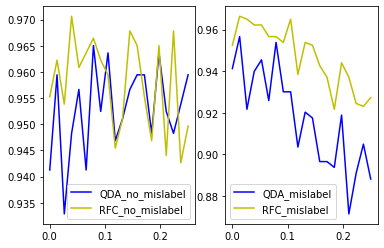

In [14]:
ps = np.linspace(0, 0.25, 20)
qdas_2 = np.zeros(len(ps))
rfcs_2 = np.zeros(len(ps))
qdas_3 = np.zeros(len(ps))
rfcs_3 = np.zeros(len(ps))

# Mean over fives loops
for j in range(5):
    # lopp for 20 p values
    for i, p in enumerate(ps):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, train_size=0.75)
        qda_2 = QuadraticDiscriminantAnalysis()
        rfc_2 = rfc = RandomForestClassifier()
        qda_2.fit(X_train, y_train)
        rfc_2.fit(X_train, y_train)
        qda_2_acc = qda_2.score(X_test, y_test)
        rfc_2_acc = rfc_2.score(X_test, y_test)
        #print(f'Accuracy QDA: {qda_2_acc}   Accuracy RFC: {rfc_2_acc}')

        # mislabel p percent of the training data
        pos = np.random.randint((len(y_train)-1), size = int(np.round(p*len(y_train))))
        y_train_flipped = y_train.copy()
        y_train_flipped[pos] -= 1
        y_train_flipped[pos] *= -1
        qda_3 = QuadraticDiscriminantAnalysis()
        rfc_3 = RandomForestClassifier()
        qda_3.fit(X_train, y_train_flipped)
        rfc_3.fit(X_train, y_train_flipped)
        qda_3_acc = qda_3.score(X_test, y_test)
        rfc_3_acc = rfc_3.score(X_test, y_test)
        #print(f'Accuracy of QDA with {p*110}% mislabeled: {qda_3_acc}    RFC:{rfc_3_acc}')
        
        qdas_2[i] += qda_2_acc
        qdas_3[i] += qda_3_acc
        rfcs_2[i] += rfc_2_acc
        rfcs_3[i] += rfc_3_acc

fig1, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(ps, qdas_2/(j+1), 'b-')
ax1.plot(ps, rfcs_2/(j+1), 'y-')
ax2.plot(ps, qdas_3/(j+1), 'b-')
ax2.plot(ps, rfcs_3/(j+1), 'y-')
ax1.legend(['QDA_no_mislabel', 'RFC_no_mislabel'])
ax2.legend(['QDA_mislabel', 'RFC_mislabel'])
plt.show()


## Question 4 (b) ##
You can use the dataset you used for the previous question as a starting point and create an imbalanced data by generating additional data points to the majority class. Or you can simulate data from scratch, perhaps inspired by feature distributions in the breast cancer data set.

To create new data objects for the majority class:

**1.** Sample two objects from the majority class at random.
**2.** Create a new X-feature by taking a weighted average of the two X-samples with weights .95 and .05 for example, the point being that it should be a feature close but not identical to an original sample.
Perform a small **simulation study**.

**1.** Choose a classification method and a sequence of at least 5 values of class imbalance between between 50 and 95 percent majority class.
**2.** Set aside a proportion of the data as a test set (think about stratification!) and use the rest as training data (e.g. 75% of the data for training and 25% of the data for testing).
**3.** Compare the prediction performance (consider different metrics here!) on the test set for each case of imbalance when you use (a) no adjustments, (b) observation weights, (c) up-, down- or other type of resampling.
For better stability of the result it is important to repeat the entire exercise a few times.

**Goal** Analyse the results in terms of degree of imbalance. How much imbalance can the algorithm withstand without re-balancing? How much does the performance metric matter?